# Conclusion

In [ ]:
results = {
    "Model" : ["Logistic", "Ridge", "Ridge y_scores >= 0.04",  "Ridge_augmented Columns", "RandomForest", "RandomForest_augmented Columns", "XGBoost"],
    "Accuracy" : [accuracy_score(y_test, y_pred_baseline),                    accuracy_score(y_test, y_pred_ridge),                   accuracy_score(y_test, y_pred_custom),
                  accuracy_score(y_test, y_aug_ridge),                        accuracy_score(y_test, y_pred_rf),                     accuracy_score(y_test, y_pred_rf_aug),
                  accuracy_score(y_test, y_pred_xgb)  ],
    "Precision" : [precision_score(y_test, y_pred_baseline, zero_division=0), precision_score(y_test, y_pred_ridge, zero_division=0), precision_score(y_test, y_pred_custom, zero_division=0),
                    precision_score(y_test, y_aug_ridge, zero_division=0),  precision_score(y_test, y_pred_rf, zero_division=0) ,     precision_score(y_test, y_pred_rf_aug, zero_division=0),
                   precision_score(y_test, y_pred_xgb, zero_division=0) ],
    "Recall" : [recall_score(y_test, y_pred_baseline, zero_division=0),       recall_score(y_test, y_pred_ridge, zero_division=0),   recall_score(y_test, y_pred_custom, zero_division=0) ,
                recall_score(y_test, y_aug_ridge, zero_division=0) ,        recall_score(y_test, y_pred_rf, zero_division=0) ,        recall_score(y_test, y_pred_rf_aug, zero_division=0),
                recall_score(y_test, y_pred_xgb, zero_division=0)]
}

results_df = pd.DataFrame(results)
best_rf_model_aug

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200,
                       random_state=123)

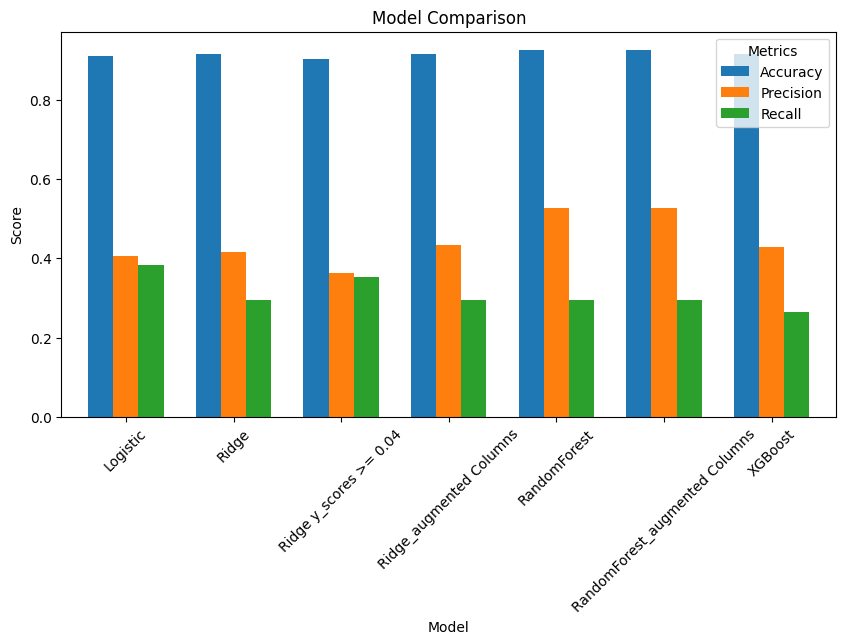

In [ ]:
results_df.set_index("Model").plot(kind="bar", figsize=(10, 5), width=0.7)
plt.title("Model Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(title="Metrics")
plt.show()

I will use the logistic regression model as the baseline model to analyze the other models. All of the models have high accuracy, which may be due to the imbalanced datasets (non-toxic molecules). RandomForest had the highest Precision, indicating that when RandomForest predicts that a drug is toxic, it is more likely to be correct than the other models. Below, I will try to analyze the important features that were found in the RandomForest. 2763 and 378 were shown to be important features, and 1226 had an increase in importance when we augmented the Columns. Therefore, I will analyze these three features.

In [ ]:
def show_substructure(mol, bit_id, bit_info):
    # Ensure bit exists in bitInfo
    if bit_id not in bit_info or len(bit_info[bit_id]) == 0:
        print(f"Bit {bit_id} not found or has no environment.")
        return None

    # Safely extract atom index and radius for the bit
    atom_idx, radius = bit_info[bit_id][0]

    # Get bonds in the radius-N environment
    env = Chem.FindAtomEnvironmentOfRadiusN(mol, radius, atom_idx)

    # Collect all atom indices from the bonds
    atoms = {atom_idx}  # Include center atom too
    for bidx in env:
        bond = mol.GetBondWithIdx(bidx)
        atoms.add(bond.GetBeginAtomIdx())
        atoms.add(bond.GetEndAtomIdx())

    # Generate 2D coordinates for layout
    from rdkit.Chem import AllChem
    AllChem.Compute2DCoords(mol)

    # Draw the molecule with highlights
    from rdkit.Chem.Draw import rdMolDraw2D
    d = rdMolDraw2D.MolDraw2DSVG(300, 300)
    d.drawOptions().addAtomIndices = True

    highlight_atoms = list(atoms)
    highlight_bonds = list(env)
    highlight_colors = {idx: (1.0, 0.2, 0.2) for idx in highlight_atoms}  # bright red

    d.DrawMolecule(
        mol,
        highlightAtoms=highlight_atoms,
        highlightBonds=highlight_bonds,
        highlightAtomColors=highlight_colors,
        highlightBondColors=highlight_colors
    )
    d.FinishDrawing()
    return d.GetDrawingText()


Molecule 2 with Bit Index: 2763


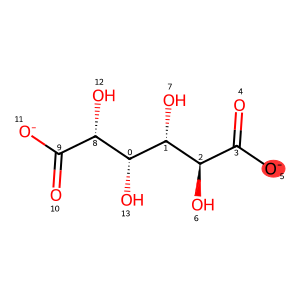

Molecule 5 with Bit Index: 2763


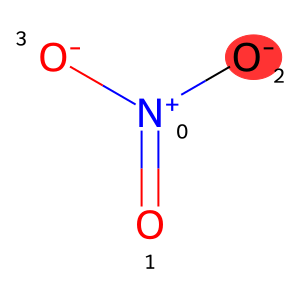

Molecule 7 with Bit Index: 2763


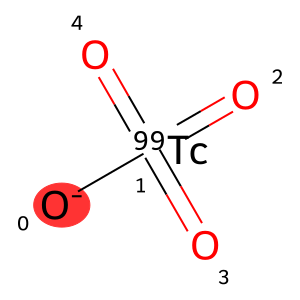

Molecule 8 with Bit Index: 2763


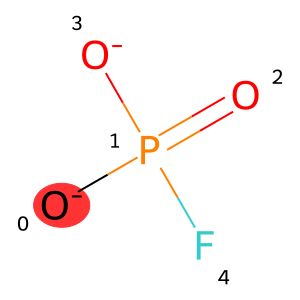

In [ ]:
from IPython.display import SVG, display
from rdkit.Chem import AllChem

bit_id = 2763
shown = 0
max_to_show = 4
for i in range(len(valid_morgan_data)):
    mol = valid_morgan_data.iloc[i]['mol']
    bit_info = valid_morgan_data.iloc[i]['bitInfo']

    if bit_id in bit_info:
        print(f"Molecule {i} with Bit Index: {bit_id}")
        svg = show_substructure(mol, bit_id, bit_info)
        if svg:
            display(SVG(svg))
            shown += 1
        if shown >= max_to_show:
            break

The code above highlights that O- is the most important feature.

Molecule 12 with Bit Index: 378


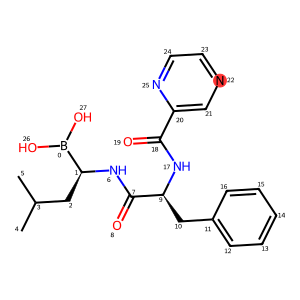

Molecule 13 with Bit Index: 378


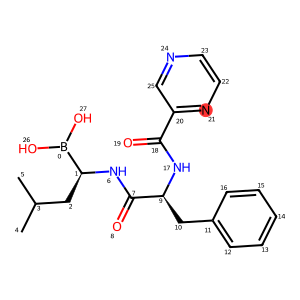

Molecule 17 with Bit Index: 378


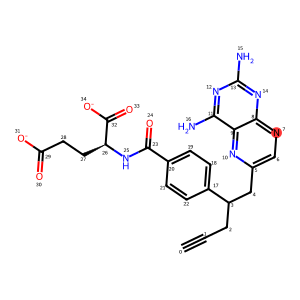

Molecule 75 with Bit Index: 378


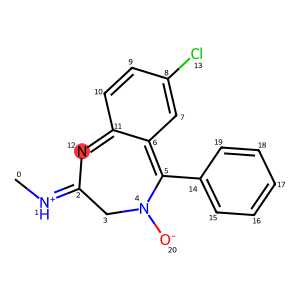

In [ ]:
bit_id = 378
shown = 0
max_to_show = 4
for i in range(len(valid_morgan_data)):
    mol = valid_morgan_data.iloc[i]['mol']
    bit_info = valid_morgan_data.iloc[i]['bitInfo']

    if bit_id in bit_info:
        print(f"Molecule {i} with Bit Index: {bit_id}")
        svg = show_substructure(mol, bit_id, bit_info)
        if svg:
            display(SVG(svg))
            shown += 1
        if shown >= max_to_show:
            break

This substructure may be nitrogen atoms within a heteroaromatic ring system

Molecule 2 with Bit Index: 1226


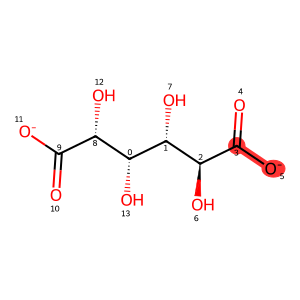

Molecule 17 with Bit Index: 1226


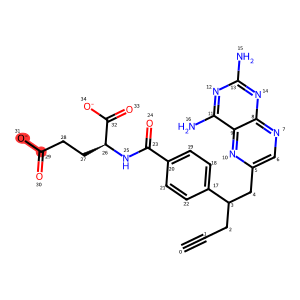

Molecule 21 with Bit Index: 1226


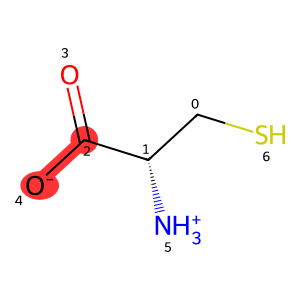

Molecule 29 with Bit Index: 1226


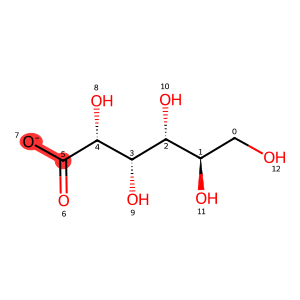

In [ ]:
bit_id = 1226
shown = 0
max_to_show = 4
for i in range(len(valid_morgan_data)):
    mol = valid_morgan_data.iloc[i]['mol']
    bit_info = valid_morgan_data.iloc[i]['bitInfo']

    if bit_id in bit_info:
        print(f"Molecule {i} with Bit Index: {bit_id}")
        svg = show_substructure(mol, bit_id, bit_info)
        if svg:
            display(SVG(svg))
            shown += 1
        if shown >= max_to_show:
            break

This substructure seems like carboxylic acid  or carboxylate

#Discussion

In [ ]:
bit_ids = [2763,  378, 1226]

for bit in bit_ids:
    # 1 if bit present, 0 otherwise
    bit_values = [1 if bit in info else 0 for info in valid_morgan_data['bitInfo']]

    # Create DataFrame for analysis
    df = pd.DataFrame({'bit': bit_values, 'label': labels})

    # Show frequency of bit in each class
    print(f"\n=== Bit {bit} ===")
    print("Fraction of molecules with this bit by class:")
    print(df.groupby('label')['bit'].mean())

    # Show Ridge coefficient
    coef = ridge_model.coef_.flatten()[bit]
    print(f"Ridge coefficient: {coef:.4f}")


=== Bit 2763 ===
Fraction of molecules with this bit by class:
label
0    0.269818
1    0.026786
Name: bit, dtype: float64
Ridge coefficient: -0.1427

=== Bit 378 ===
Fraction of molecules with this bit by class:
label
0    0.234909
1    0.517857
Name: bit, dtype: float64
Ridge coefficient: 0.0467

=== Bit 1226 ===
Fraction of molecules with this bit by class:
label
0    0.193455
1    0.017857
Name: bit, dtype: float64
Ridge coefficient: -0.0849


It seems like the O- and COOH group are more common in non-toxic groups, while N-heterocycle is associated with toxicity.